In [16]:
import tensorflow as tf
#print("TensorFlow version: {}".format(tf.__version__))
#print("Eager execution: {}".format(tf.executing_eagerly()))

In [17]:

from keras.preprocessing import image
from keras import applications
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras import backend as K
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [18]:
# build the VGG16 network
model = applications.VGG16(include_top=True, weights='imagenet')

# get the symbolic outputs of each "key" layer
layer_dict = dict([(layer.name, layer) for layer in model.layers])

for layer in model.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


2020-11-08 16:49:02 URL:https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg [83281/83281] -> "ex01.jpg" [1]


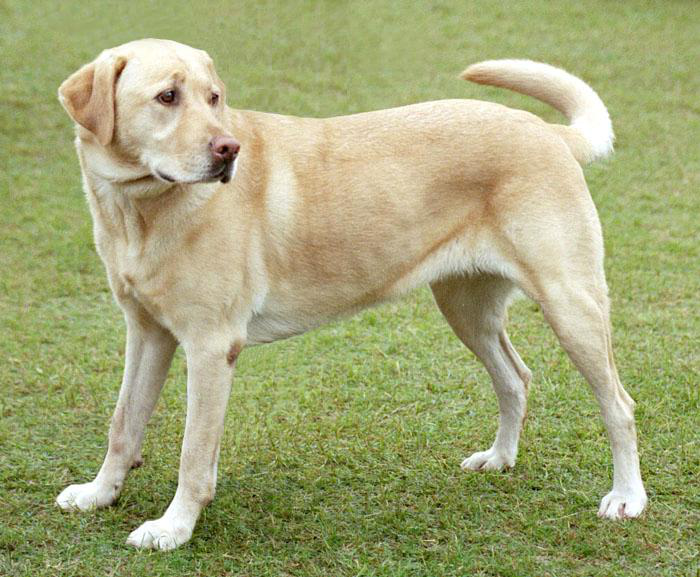

In [19]:
# Load a sample image
!wget -nv https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg -O ex01.jpg

img = Image.open('./ex01.jpg')
img

In [20]:
img_path = './ex01.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
print('image.img_to_array: ', x.shape, np.max(x), np.min(x))
x = np.expand_dims(x, axis=0)
print('expand_dims: ', x.shape, np.max(x), np.min(x))
x = preprocess_input(x)
print('preprocess_input: ', x.shape, np.max(x), np.min(x))

image.img_to_array:  (224, 224, 3) 255.0 0.0
expand_dims:  (1, 224, 224, 3) 255.0 0.0
preprocess_input:  (1, 224, 224, 3) 151.061 -123.68


In [21]:
# util function to convert a tensor into a valid image
def tensor2image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.2
    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [22]:
preds = model.predict(x)
# Get results into a list of tuples (class, description, probability)
print('Predicted:', decode_predictions(preds, top=3)[0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Predicted: [('n02099712', 'Labrador_retriever', 0.36154303), ('n02099601', 'golden_retriever', 0.21837224), ('n02099849', 'Chesapeake_Bay_retriever', 0.049494307)]


In [23]:
model_out = K.mean(layer_dict['fc2'].output)
# compute the gradient of the input picture wrt this loss
grads = K.gradients(model_out, model.input)[0]

# Normalize the gradient
grads /= K.std(grads) + 1e-8

# function: returns the loss and grads given the input picture
model_predictor = K.function([model.input], [model_out, grads])

In [24]:
# feed  the image to the network
model_outputs, grads_values = model_predictor([x])

In [25]:
# get the grads that have the same shape  as the input image  
abs_grads_values = np.abs(grads_values)
sm = tensor2image(abs_grads_values[0])
print(sm.shape)

(224, 224, 3)


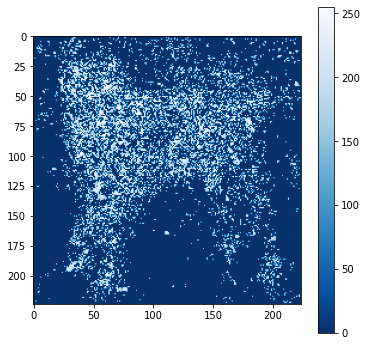

In [26]:
# let's see the grads as an image
gs = sm[:,:,0] + sm[:,:,1] + sm[:,:,2]
gs[gs<150] = 0
plt.figure(figsize=(6,6))
plt.imshow(gs, cmap='Blues_r')
plt.colorbar()

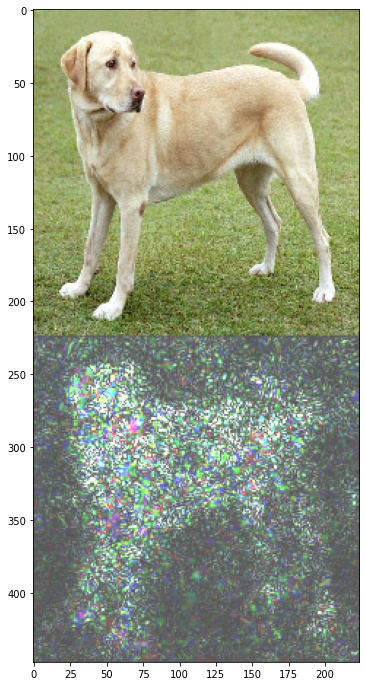

In [27]:

x1 = image.img_to_array(img).astype('uint8')
concan = np.concatenate((x1, sm), axis=0) 
plt.figure(figsize=(12,12))
plt.imshow(concan)